# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
import datetime
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.land_cover_properties

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)


## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS (in UTM coordinates) that is included in the shapefile. 

<span style="color:blue;">If the CRS is in lat-lon (in degrees), convert it to UTM (in meters).</span>


In [3]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = '../../data/Coweeta/sources/shapefile/coweeta_basin.shp'
coweeta_landcover = '../../data/Coweeta/sources/land_cover/land_cover.tif'
coweeta_glhymps = '../../data/Coweeta/sources/GLHYMPS/GLHYMPS.shp'
coweeta_dtb = '../../data/Coweeta/sources/DTB/DTB.tif'
coweeta_modis_lulc = '../../data/Coweeta/sources/land_cover/MODIS/MCD12Q1.006_500m_aid0001.nc'
coweeta_modis_lai = '../../data/Coweeta/sources/land_cover/MODIS/MCD15A3H.006_500m_aid0001.nc'

outputs = {} # this will store all the filenames used in input file

hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
huc = None # provide the huc code for that watershed. If None, the script will automatically search for the HUC code.
simplify = 30 # length scale to target average edge

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start = datetime.date(2010,8,1)
end = datetime.date(2011,8,1)

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
crs, coweeta = watershed_workflow.get_split_form_shapes(coweeta_shapefile)

2023-06-29 22:36:26,325 - root - INFO: 
2023-06-29 22:36:26,329 - root - INFO: Meshing shape: ../../data/Coweeta/sources/shapefile/coweeta_basin.shp
2023-06-29 22:36:26,336 - root - INFO: ==============================
2023-06-29 22:36:26,340 - root - INFO: 
2023-06-29 22:36:26,343 - root - INFO: Loading shapes
2023-06-29 22:36:26,345 - root - INFO: ------------------------------
2023-06-29 22:36:26,349 - root - INFO: Loading file: '../../data/Coweeta/sources/shapefile/coweeta_basin.shp'
2023-06-29 22:36:26,535 - root - INFO: ... found 1 shapes
2023-06-29 22:36:26,539 - root - INFO: Converting to shapely


In [4]:
crs

<Derived Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 84°W and 78°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Florida; Georgia; Kentucky; Maryland; Michigan; New York; North Carolina; Ohio; Pennsylvania; South Carolina; Tennessee; Virginia; West Virginia.
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Sources

A wide range of data sources are available and shown below:

| source | File_Manager | Options|
|:---:|:---:|:---:|
|sources['DEM']| `FileManagerNED()` | `1 arc-second` (*); `1/3 arc-second`|
|sources['HUC']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`; `WBD`|
|sources['hydrography']| `FileManagerNHD()` | `NHDPlus` (*); `NHD`|
|sources['land cover']| `FileManagerNLCD()` | `NLCD (L48)` (*); `NLCD (AK)`; `MODIS`|
|sources['geologic structure']| `FileManagerGLHYMPS()` | `GLHYMPS` (*)|
|sources['soil structure']| `FileManagerNRCS()` | `NRCS SSURGO` (*)|
|sources['DTB']| `FileManagerSoilGrids2017()` | `SoilGrids2017` (*)|
|sources['lai']| `FileManagerMODISAppEEARS()` | `MODIS` (*)|
|sources['meteorology']| `FileManagerDaymet()` | `DayMet` (*)|

Note, custom sources can be imported using:

```python
# if raster
sources['SOURCE NAME'] = watershed_workflow.source_list.FileManagerRaster('PATH/TO/RASTER')

# for example
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster('./Global_absoluteDTB_M_250m_ll.tif')
```

By default, Watershed-Workflow (WW) will place all the downloads in a folder named `data_library` or the mounted data volume and has the following structure (generated by WW):

```bash
.
├── dem
│   ├── 13as_raw
│   └── 1as_raw
├── hydrography
├── land_cover
│   ├── MODIS
│   ├── NLCD_2016_Land_Cover_L48
│   └── NLCD_2019_Land_Cover_L48
├── meteorology
│   └── daymet
└── soil_structure
    ├── GLHYMPS
    ├── SSURGO
    ├── SoilGrids2017
    └── depth-to-bedrock
```

Some of the sources do not have API and they need to be downloaded manually. Here are a list of sources to download:

| source | Download Link| Local Path| Notes|
|:---:|:---:|:---:|:---:|
| GLHYMPS v2  | [link](https://doi.org/10.5683/SP2/TTJNIU) | `data/soil_structure/GLHYMPS`| ~2.4 GB. Unzip the .zip file and place all the files under the path|
| Depth-to-bedrock (~2.4 GB) | [Link](http://globalchange.bnu.edu.cn/research/dtb.jsp) | `data/soil_structure/depth-to-bedrock`| ~10 GB. Look for file named `Global_absoluteDTB_M_250m_ll.tif` (250 m resolution). This file is slightly different from the data found in [SoilGrids](https://soilgrids.org/). Why?|

In [5]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
# sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017()

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster(coweeta_landcover)
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS(coweeta_glhymps)
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster(coweeta_dtb)
# sources['MODIS LULC'] = watershed_workflow.source_list.FileManagerRaster(coweeta_modis_lulc)

watershed_workflow.source_list.log_sources(sources)

2023-06-29 22:36:26,801 - root - INFO: Using sources:
2023-06-29 22:36:26,804 - root - INFO: --------------
2023-06-29 22:36:26,808 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-06-29 22:36:26,811 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-06-29 22:36:26,815 - root - INFO: DEM: National Elevation Dataset (NED)
2023-06-29 22:36:26,819 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-06-29 22:36:26,822 - root - INFO: geologic structure: ../../data/Coweeta/sources/GLHYMPS/GLHYMPS.shp
2023-06-29 22:36:26,824 - root - INFO: land cover: raster
2023-06-29 22:36:26,827 - root - INFO: lai: MODIS
2023-06-29 22:36:26,830 - root - INFO: soil thickness: None
2023-06-29 22:36:26,838 - root - INFO: meteorology: DayMet 1km
2023-06-29 22:36:26,842 - root - INFO: depth to bedrock: raster


In [6]:
# immediately put in request for land cover data -- downloading from Appeears
# can take some time as they must synthesize the data 

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

In [7]:
# find what HUC our shape is in
if huc is None:
    huc = watershed_workflow.find_huc(sources['HUC'], coweeta.exterior(), crs, hint, shrink_factor=0.1)
    logging.info("Found Coweeta in HUC: {}".format(huc))

2023-06-29 22:36:27,108 - root - INFO: 
2023-06-29 22:36:27,113 - root - INFO: Loading HUC 0601
2023-06-29 22:36:27,115 - root - INFO: ------------------------------
2023-06-29 22:36:27,120 - root - INFO: 
2023-06-29 22:36:27,123 - root - INFO: Loading level 4 HUCs in 0601
2023-06-29 22:36:27,126 - root - INFO: ------------------------------
2023-06-29 22:36:27,138 - root - INFO: Using HUC file "/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2023-06-29 22:36:28,134 - root - INFO: ... found 1 HUCs
2023-06-29 22:36:28,137 - root - INFO:   -- 0601
2023-06-29 22:36:28,146 - root - INFO: Converting to out_crs
2023-06-29 22:36:28,541 - root - INFO: Converting to shapely
2023-06-29 22:36:28,665 - root - INFO: ... found 1
2023-06-29 22:36:28,718 - root - INFO: Found Coweeta in HUC: 0601


In [8]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                      coweeta.exterior(), crs, crs, properties=True)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = watershed_workflow.construct_rivers(coweeta, reaches, method='hydroseq')
    rivers = watershed_workflow.simplify(coweeta, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                               snap_rivers=True, cut_intersections=True)

else:
    rivers = list()
    watershed_workflow.split_hucs.simplify(coweeta, simplify)



2023-06-29 22:36:28,839 - root - INFO: 
2023-06-29 22:36:28,843 - root - INFO: Loading Hydrography
2023-06-29 22:36:28,847 - root - INFO: ------------------------------
2023-06-29 22:36:28,849 - root - INFO: Loading streams in HUC 0601
2023-06-29 22:36:28,854 - root - INFO:          and/or bounds (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2023-06-29 22:36:28,858 - root - INFO:   Using Hydrography file "/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2023-06-29 22:36:28,860 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/home/jovyan/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)'
2023-06-29 22:36:31,425 - root - INFO:   Found total of 36 in bounds.
2023-06-29 22:36:31,431 - root - INFO:   Filtering reaches not in-network
2023-06-29 22:36:31,435 - root - INFO:   Natio

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


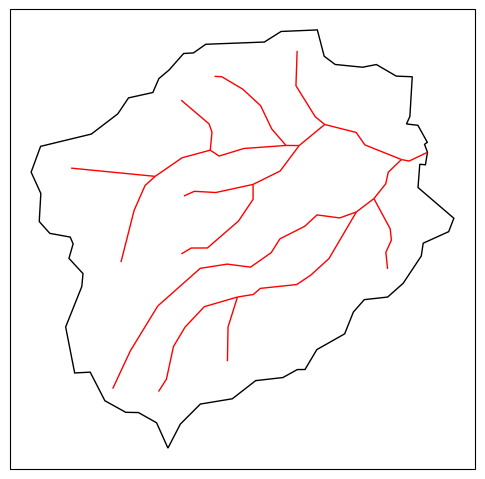

In [9]:
# plot what we have so far -- an image of the HUC and its stream network
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

watershed_workflow.plot.hucs(coweeta, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)

plt.show()

### Meshing

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle centroid to the nearest stream. A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

Adjust distance and area parameters to refine triangles. 

<span style="color:blue;"> Be careful with the min triangular area (e.g., \<1 m^2) in the meshes. It will likely cause the model to run extremely slowly. You may also receive an error saying the tolerance value (i.e., the minimum node distance) is too small.</span> You can increase the smoothing parameter such as `simplify_hucs` or `simplify_rivers` to make the boundaries smoother and meshes coarser.


2023-06-29 22:39:36,958 - root - INFO: 
2023-06-29 22:39:36,962 - root - INFO: Meshing
2023-06-29 22:39:36,965 - root - INFO: ------------------------------
2023-06-29 22:39:37,003 - root - INFO: Triangulating...
2023-06-29 22:39:37,011 - root - INFO:    62 points and 62 facets
2023-06-29 22:39:37,015 - root - INFO:  checking graph consistency
2023-06-29 22:39:37,017 - root - INFO:  tolerance is set to 1
2023-06-29 22:39:37,029 - root - INFO:  building graph data structures
2023-06-29 22:39:37,041 - root - INFO:  triangle.build...
2023-06-29 22:40:06,475 - root - INFO:   ...built: 8070 mesh points and 15912 triangles
2023-06-29 22:40:06,481 - root - INFO: Plotting triangulation diagnostics
2023-06-29 22:43:02,153 - root - INFO:   min area = 289.77447509765625
2023-06-29 22:43:02,157 - root - INFO:   max area = 4988.35595703125


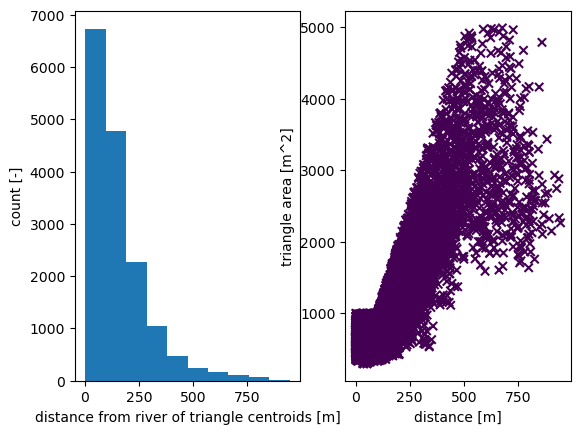

In [10]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500 # distance in meters
A0 = 1000; A1 = 5000 # triangular area in m^2
#A0 = 500; A1 = 2500
#A0 = 100; A1 = 500

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, dists = watershed_workflow.triangulate(coweeta, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [11]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], coweeta.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2023-06-29 22:43:05,095 - root - INFO: 
2023-06-29 22:43:05,099 - root - INFO: Loading Raster
2023-06-29 22:43:05,103 - root - INFO: ------------------------------
2023-06-29 22:43:05,109 - root - INFO: Collecting raster
2023-06-29 22:43:05,131 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944037, -83.41165773504302, 35.08381933600275]
2023-06-29 22:43:05,146 - root - INFO:   Need:
2023-06-29 22:43:05,150 - root - INFO:     /home/jovyan/data/dem/USGS_NED_1as_n36_w084.tif
2023-06-29 22:43:05,157 - root - INFO: source files already exist!
2023-06-29 22:43:05,350 - root - INFO: ... got raster of shape: (239, 276)
2023-06-29 22:43:05,361 - root - INFO: ... got raster bounds: (-83.48845037186388, 35.08381933600275, -83.41178370519467, 35.01743044711165)


Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(3878000.0, 0, ''),
 Text(3879000.0, 0, ''),
 Text(3880000.0, 0, ''),
 Text(3881000.0, 0, ''),
 Text(3882000.0, 0, ''),
 Text(3883000.0, 0, ''),
 Text(3884000.0, 0, ''),
 Text(3885000.0, 0, '')]

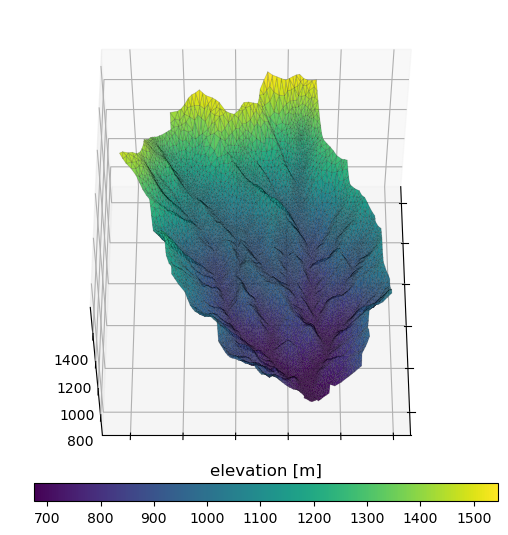

In [12]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = watershed_workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(55,0)
ax.set_xticklabels(list())
ax.set_yticklabels(list())


(273391.6231597869, 279720.3829351625)
(3878583.928534328, 3884209.4927791064)


Text(0.5, 1.0, 'elevation [m]')

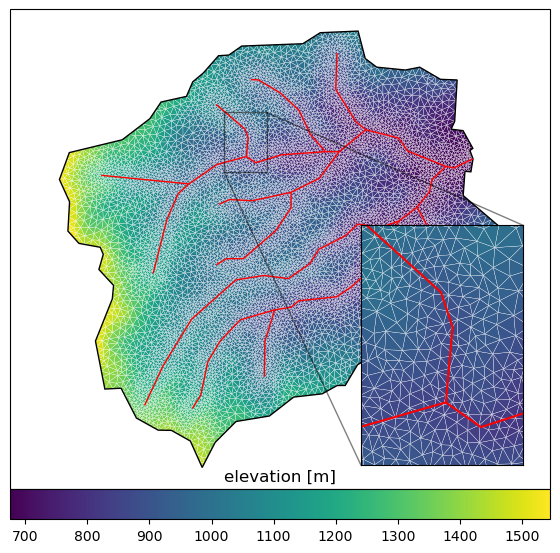

In [13]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
#ax2 = watershed_workflow.plot.get_ax(crs,fig, window=[0.65,0.05,0.3,0.5])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
watershed_workflow.plot.hucs(coweeta, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
watershed_workflow.plot.hucs(coweeta, crs, ax=ax2, color='k', linewidth=1)
watershed_workflow.plot.rivers(rivers, crs, ax=ax2, color='red', linewidth=1.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')


print(ax.get_xlim())
print(ax.get_ylim())
cbar.ax.set_title('elevation [m]')


In [14]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

Condition the mesh to remove pits and ponds in the meshes. <span style="color:blue;">Advanced tip: use `fill_pits_dual(m2, is_waterbody=waterbody_mask) ` if there exists lakes or reservoirs where pits should not be removed! </span>

max diff =  6.589355426018074


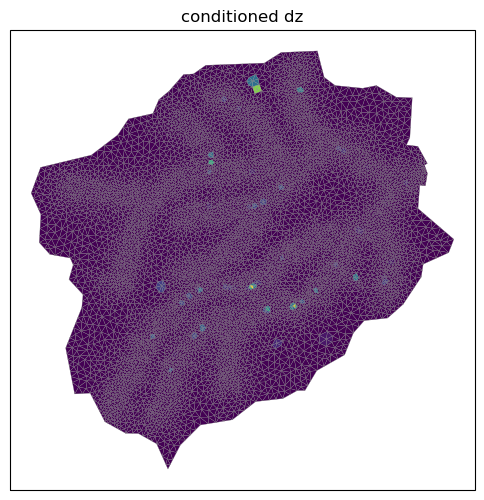

In [15]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fill_pits(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.points[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=figsize)
watershed_workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### Add watershed outlet (optional)

This will add the outlet region in the mesh for better capturing the streamflow in post-processing. Here there is only one outlet. However, this may be necessary for watershed with multiple subcatchments with multiple outlets.

In [16]:
# add labeled sets for subcatchments and outlets. Here we use BASIN_CODE, but any other code would work.
stream_outlet_width = 500  # half-width to track a labeled set on which to get discharge. Use large values to be conservative.
watershed_polygons = list(coweeta.polygons())
outlet_labels = ["060102020103"] # use HUC code for the label
watershed_workflow.mesh.add_watershed_regions_and_outlets(m2, watershed_polygons, 
                                                rivers, stream_outlet_width, labels = outlet_labels)
                                               # labels=[str(p.properties['BASIN_CODE']) for p in watershed_polygons])

In [17]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "060102020103"
10001 : CELL : "060102020103 surface"
10002 : FACE : "060102020103 boundary"
10003 : FACE : "060102020103 outlet"


## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

### Land Cover

In [18]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     coweeta.exterior(), crs)

# resample the raster to the triangles
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2023-06-29 22:43:37,103 - root - INFO: 
2023-06-29 22:43:37,106 - root - INFO: Loading Raster
2023-06-29 22:43:37,109 - root - INFO: ------------------------------
2023-06-29 22:43:37,115 - root - INFO: Collecting raster
2023-06-29 22:43:37,369 - root - INFO: bounds in my_crs: (1129295.2795605154, 1404623.589663599, 1134445.5249579642, 1410000.8473879488)
2023-06-29 22:43:37,378 - root - INFO: ... got raster of shape: (180, 173)
2023-06-29 22:43:37,436 - root - INFO: ... got raster bounds: (1129275.0, 1410015.0, 1134465.0, 1404615.0)
2023-06-29 22:43:39,434 - root - INFO: Found land cover dtypes: uint8
2023-06-29 22:43:39,449 - root - INFO: Found land cover types: {41, 42, 43, 81, 52, 21, 22, 23}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x40968a3850>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x40968a2d10>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [21 43 43 ... 41 41 43]


Text(0.5, 1.0, 'NLCD land cover index')

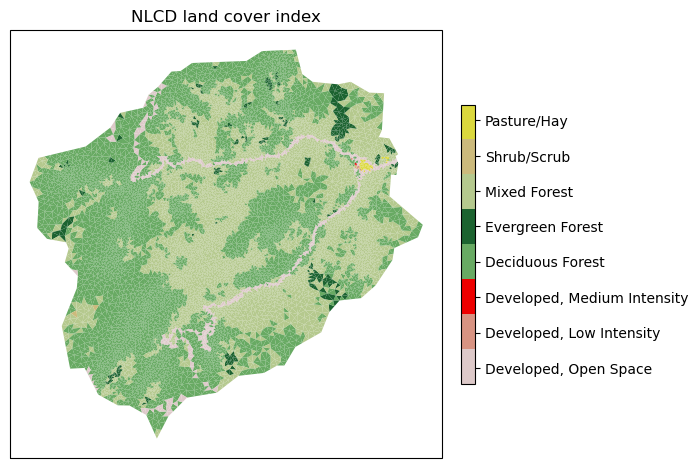

In [19]:
# plot the NLCD data

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, 
                                     norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(nlcd_indices), cmap=nlcd_cmap, 
                                         labels=nlcd_labels) 
ax.set_title("NLCD land cover index")

### LAI

Download MODIS LAI and LULC, block until it is finished!
NOTE: if you get an error here about MODIS AppEEARs username and password, realize that you must register for a login in the AppEEARs database.  See: `print(sources['lai'].__doc__)`

You may encounter download issues if the files are too big. In that case, manually download the MODIS data using [AppEEARS](https://appeears.earthdatacloud.nasa.gov/). Here are brief steps:

1. Sign in if you already registered. 
2. Click `Extract --> Area`
3. Click `Start a new request`
4. Upload the watershed shapefile (in lat-lon). <span style="color:blue;"> Important: draw a box region surrounding the watershed to avoid downloading no_data! </span>
5. Choose `Start Date` (e.g., 2002-7-1) and `End Date` (e.g., 2021-1-1)
6. Select product for Landcover (e.g., `MCD12Q1.006`) or LAI (e.g., `MCD15A3H.006`)
7. Select layers or for landcover (i.e., `LC_Type1`) or LAI (i.e., `Lai_500m`). You may choose to include all layers, but not all will be used.
8. Select `NetCDF-4` as the output file format 
9. Click `Submit`. It will send an email after download is completed.

In [20]:
## Uncomment the next three lines if you want to try downloading through WW
# modis = sources['lai'].get_data(coweeta.exterior(), crs, start, end)
# if not isinstance(modis, watershed_workflow.datasets.State):
#     modis = sources['lai'].wait(modis)
modis = sources['lai'].get_data(coweeta.exterior(), crs, start, end, variables = ['LULC', 'LAI'], filenames=[coweeta_modis_lulc, coweeta_modis_lai])

2023-06-29 23:00:28,666 - root - INFO: ... reading LULC from ../../data/Coweeta/sources/land_cover/MODIS/MCD12Q1.006_500m_aid0001.nc
2023-06-29 23:00:28,816 - root - INFO: ... reading LAI from ../../data/Coweeta/sources/land_cover/MODIS/MCD15A3H.006_500m_aid0001.nc


In [21]:
# resample the raster to the triangles
modis_lc = watershed_workflow.values_from_raster(m2.centroids, crs, modis['LULC'].data[0,:,:], 
                                                 modis['LULC'].profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
logging.info('Found land cover types: {}'.format(set(modis_lc)))

2023-06-29 23:00:29,368 - root - INFO: Found land cover dtypes: int16
2023-06-29 23:00:29,384 - root - INFO: Found land cover types: {4}


kwargs =  {'cmap': <matplotlib.colors.ListedColormap object at 0x409637d900>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x409637f280>, 'edgecolor': 'none', 'linewidth': 0.5}
setting face color =  [21 43 43 ... 41 41 43]


Text(0.5, 1.0, 'MODIS land cover index')

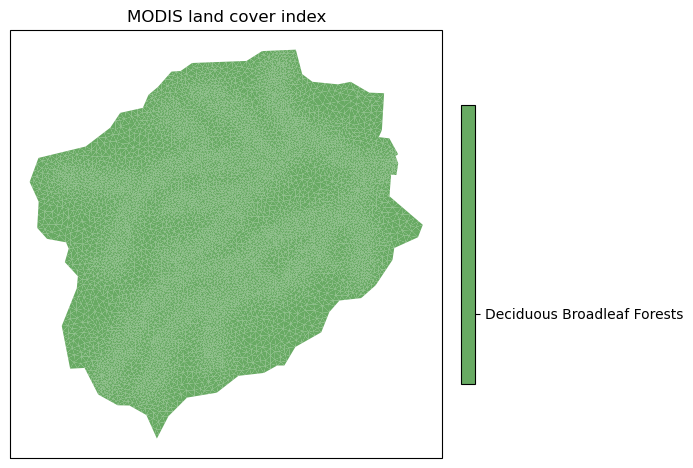

In [22]:
# plot the modis lulc data

# -- get the MODIS colormap which uses official MODIS colors and labels
modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(modis_lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=modis_cmap, 
                                     norm=modis_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(modis_indices), cmap=modis_cmap, 
                                         labels=modis_labels) 
ax.set_title("MODIS land cover index")

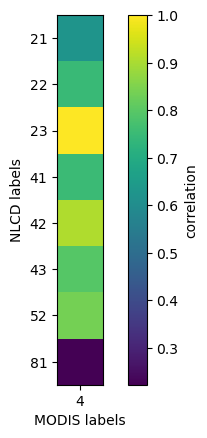

In [23]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best.  Note that while it is obvious here that
# all NLCD will map to MODIS 4, we do it anyway because this will not be true in general
unique_nlcd = list(np.unique(lc))
unique_modis = modis_indices

crosswalk = watershed_workflow.land_cover_properties.compute_crosswalk_correlation(
    modis['LULC'].profile, modis['LULC'].data[0,:,:], lc_profile, lc_raster, unique_nlcd = unique_nlcd, unique_modis=unique_modis)

In [24]:
crosswalk

{21: 4, 22: 4, 23: 4, 41: 4, 42: 4, 43: 4, 52: 4, 81: 4}

In [25]:
# compute area averaged LAI for each modis land cover
lai_time_series = watershed_workflow.land_cover_properties.compute_time_series(
    modis['LAI'], modis['LULC'], unique_lc = unique_modis)
lai_time_series

time [datetime]  Deciduous Broadleaf Forests LAI [-]
0         2002-07-04                             5.259259
1         2002-07-08                             3.559259
2         2002-07-12                             4.074074
3         2002-07-16                             4.903704
4         2002-07-20                             5.266667
...              ...                                  ...
1694      2020-12-18                             0.618519
1695      2020-12-22                             0.496296
1696      2020-12-26                             0.537037
1697      2020-12-30                             0.600000
1698      2021-01-01                             0.666667

[1699 rows x 2 columns]

In [26]:
# write raw LAI to disk
filename = os.path.join('..', '..', 'data', 'Coweeta', 'processed', 'coweeta_lai.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, lai_time_series)                                            

2023-06-29 23:11:55,761 - root - INFO: Writing HDF5 file: ../../data/Coweeta/processed/coweeta_lai.h5


## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [27]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [coweeta.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    coweeta.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



2023-06-29 23:11:55,969 - root - INFO: 
2023-06-29 23:11:55,971 - root - INFO: Loading shapes
2023-06-29 23:11:55,973 - root - INFO: ------------------------------
2023-06-29 23:11:56,169 - root - INFO: Attempting to download source for target '/home/jovyan/data/soil_structure/SSURGO/SSURGO_-83.4790_35.0269_-83.4208_35.0743.shp'
2023-06-29 23:11:56,344 - root - INFO:   Found 490 shapes.
2023-06-29 23:11:56,354 - root - INFO:   and crs: epsg:4326
2023-06-29 23:11:56,356 - root - INFO:   Downloaded 490 total shapes
2023-06-29 23:11:56,360 - root - INFO:   Downloaded 43 unique mukeys
2023-06-29 23:11:57,756 - root - INFO: found 43 unique MUKEYs.
2023-06-29 23:12:03,931 - root - INFO: Running Rosetta for van Genutchen parameters
2023-06-29 23:12:05,152 - root - INFO:   ... done
2023-06-29 23:12:05,166 - root - INFO:   requested 43 values
2023-06-29 23:12:05,168 - root - INFO:   got 43 responses
2023-06-29 23:12:05,235 - root - INFO: ... found 43 shapes
2023-06-29 23:12:05,238 - root - INFO

In [28]:
soil_color = soil_color.astype(int)

In [29]:
soil_survey_props

mukey  residual saturation [-]  Rosetta porosity [-]  \
0   545800                 0.177165              0.431041   
1   545801                 0.177493              0.432741   
2   545803                 0.172412              0.400889   
3   545805                 0.177122              0.388687   
4   545806                 0.177122              0.388687   
5   545807                 0.177122              0.388687   
6   545811                 0.185628              0.387114   
7   545812                 0.185628              0.387114   
8   545813                 0.183468              0.398767   
9   545814                 0.183216              0.399168   
10  545815                 0.177808              0.408626   
11  545817                 0.161194              0.457152   
12  545818                 0.176724              0.454692   
13  545819                 0.179179              0.453829   
14  545820                 0.176724              0.454692   
15  545829                 0.195475              0.370974   
16  545830                 0.195431              0.370396   
17  545831                 0.195360              0.369401   
18  545835                 0.202983              0.420460   
19  545836                 0.225964              0.380189   
20  545837                 0.219777              0.382865   
21  545838                 0.224883              0.381193   
22  545842                 0.193278              0.412219   
23  545843                 0.200565              0.409655   
24  545849                 0.148885              0.384451   
25  545852                 0.174940              0.395697   
26  545853                 0.174940              0.395697   
27  545854                 0.174940              0.395697   
28  545855                 0.149582              0.384703   
29  545857                 0.175471              0.416598   
30  545859                 0.209607              0.381582   
31  545860                 0.210433              0.385251   
32  545861                 0.202264              0.393882   
33  545862                 0.208942              0.381575   
34  545863                 0.208942              0.381575   
35  545874                 0.208675              0.399614   
36  545875                 0.208675              0.399614   
37  545876                 0.184037              0.452018   
38  545878                 0.196924              0.425599   
39  545882                 0.184498              0.361656   
40  545885                 0.165660              0.400572   
41  545886                 0.165660              0.400572   
42  545887                 0.165660              0.400572   

    van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
0                      0.000139             1.470755   
1                      0.000139             1.469513   
2                      0.000150             1.491087   
3                      0.000083             1.468789   
4                      0.000083             1.468789   
5                      0.000083             1.468789   
6                      0.000166             1.473045   
7                      0.000166             1.473045   
8                      0.000127             1.445858   
9                      0.000125             1.445793   
10                     0.000162             1.498482   
11                     0.000168             1.559659   
12                     0.000151             1.479294   
13                     0.000149             1.469380   
14                     0.000151             1.479294   
15                     0.000131             1.409385   
16                     0.000132             1.409349   
17                     0.000134             1.409332   
18                     0.000125             1.404309   
19                     0.000118             1.356194   
20                     0.000117             1.368452   
21                     0.000114             1.359591   
22                     0.000142 

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x4095be3f40>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x4095be1660>}
setting face color =  [545882 545882 545853 ... 545800 545800 545814]


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

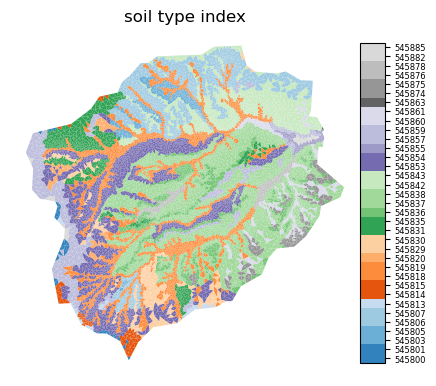

In [30]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')



Index(['mukey', 'residual saturation [-]', 'Rosetta porosity [-]',
       'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]',
       'Rosetta permeability [m^2]', 'thickness [cm]', 'permeability [m^2]',
       'porosity [-]', 'bulk density [g/cm^3]', 'total sand pct [%]',
       'total silt pct [%]', 'total clay pct [%]', 'source'],
      dtype='object')
min, max =  0.2355549116198203 0.46629921741913594


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

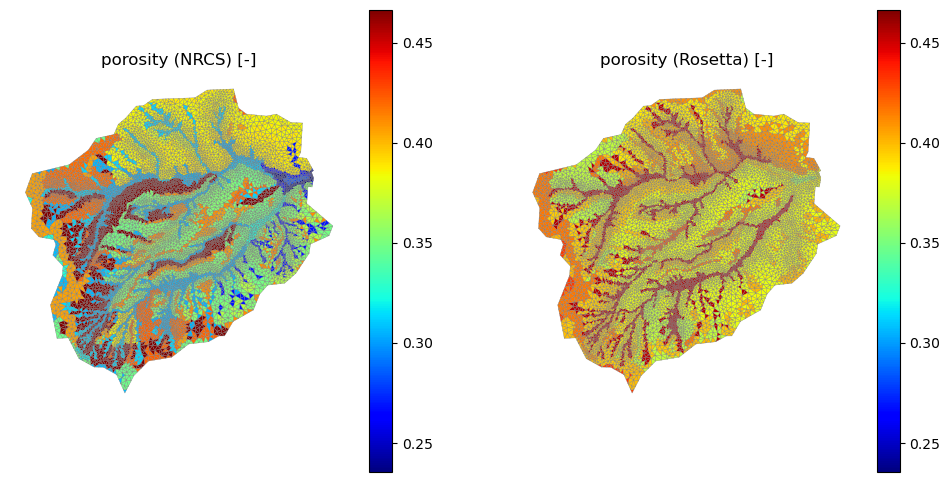

In [31]:
# Note this is not just the soil ID, but also soil properties.  
print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)

# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)


fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')


min = -14.488486163789586, max = -11.204929002586569


Text(0.5, 1.0, 'log permeability (Rosetta) [m^2]')

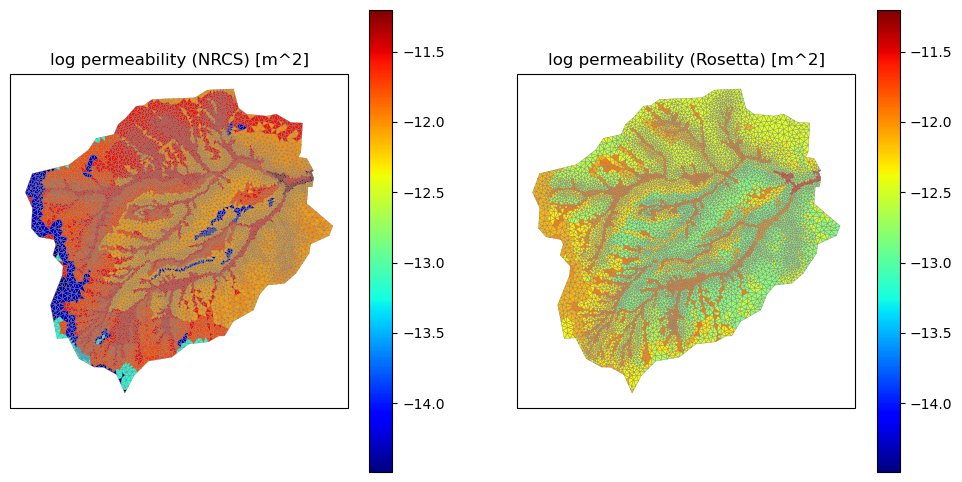

In [32]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.log10(soil_perm_nrcs).min(), np.log10(soil_perm_rosetta).min())
pmax = max(np.log10(soil_perm_nrcs).max(), np.log10(soil_perm_rosetta).max())

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




[203. 203. 203. ... 203. 203. 203.]


/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Median soil thickness = 2.03 [m]


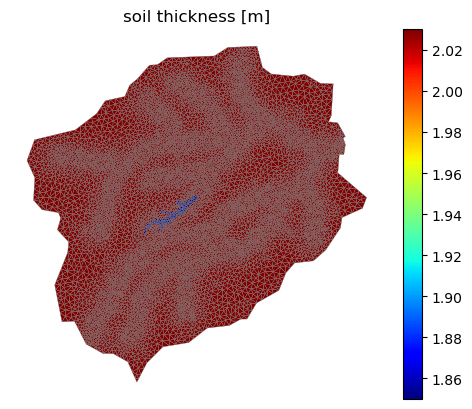

In [38]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

print(soil_thickness)
soil_thickness = soil_thickness / 100
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print(f'Median soil thickness = {np.nanmedian(soil_thickness)} [m]')

In [39]:
def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows, use all cols as duplicate target
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

In [40]:
def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

In [43]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
# soil_survey_props_clean = soil_survey_props.copy()
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
# soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
# soil id with missing properties will be removed, and the space will be filled by geology from below (see mesh extrusion)!
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

# remove duplicates
reindex_remove_duplicates(soil_survey_props_clean, 'native_index')

# assert soil_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert soil_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
soil_survey_props_clean

native_index  residual saturation [-]  \
0                  (545849,)                 0.177165   
1                  (545855,)                 0.177493   
2                  (545817,)                 0.172412   
3                  (545887,)                 0.177122   
4                  (545885,)                 0.185628   
5                  (545886,)                 0.183468   
6                  (545803,)                 0.183216   
7           (545852, 545854)                 0.177808   
8                  (545853,)                 0.161194   
9                  (545857,)                 0.176724   
10          (545818, 545820)                 0.179179   
11  (545805, 545806, 545807)                 0.195475   
12                 (545800,)                 0.195431   
13                 (545801,)                 0.195360   
14                 (545815,)                 0.202983   
15                 (545819,)                 0.225964   
16                 (545814,)                 0.219777   
17                 (545813,)                 0.224883   
18                 (545876,)                 0.193278   
19                 (545882,)                 0.200565   
20          (545811, 545812)                 0.148885   
21                 (545842,)                 0.174940   
22                 (545831,)                 0.174940   
23                 (545830,)                 0.149582   
24                 (545829,)                 0.175471   
25                 (545878,)                 0.209607   
26                 (545843,)                 0.210433   
27                 (545861,)                 0.202264   
28                 (545835,)                 0.208942   
29          (545874, 545875)                 0.208675   
30          (545862, 545863)                 0.184037   
31                 (545859,)                 0.196924   
32                 (545860,)                 0.184498   
33                 (545837,)                 0.165660   
34                 (545838,)                 0.165660   
35                 (545836,)                 0.165660   

    van Genuchten alpha [Pa^-1]  van Genuchten n [-]  thickness [m]  \
0                      0.000139             1.470755           2.03   
1                      0.000139             1.469513           2.03   
2                      0.000150             1.491087           2.03   
3                      0.000083             1.468789           2.03   
4                      0.000166             1.473045           2.03   
5                      0.000127             1.445858           2.03   
6                      0.000125             1.445793           2.03   
7                      0.000162             1.498482           2.03   
8                      0.000168             1.559659           2.03   
9                      0.000151             1.479294           2.03   
10                     0.000149             1.469380           2.03   
11                     0.000131             1.409385           2.03   
12                     0.000132             1.409349           2.03   
13                     0.000134             1.409332           2.03   
14                     0.000125             1.404309           2.03   
15                     0.000118             1.356194           2.03   
16                     0.000117             1.368452           2.03   
17                     0.000114             1.359591           2.03   
18                     0.000142             1.434838           2.03   
19                     0.000118             1.409272           2.03   
20                     0.000238             1.853042           2.03   
21                     0.000127             1.464370           2.03   
22                     0.000127             1.464370           2.03   
23                     0.000247             1.928427           2.03   
24                     0.000147             1.484106           2.03   
25                     0.000108             1.389431        

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x40a172fa60>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x40a172f8e0>}
setting face color =  [1019 1019 1008 ... 1012 1012 1016]


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

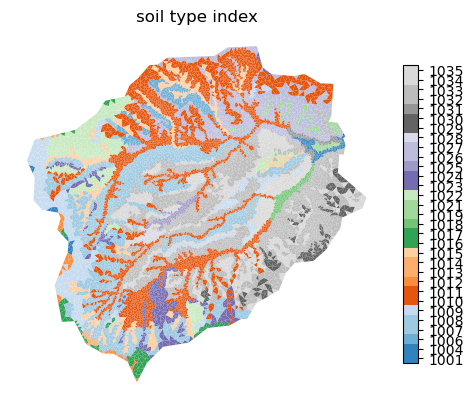

In [44]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukeys in enumerate(soil_survey_props_clean['native_index']):
    for mukey in mukeys:
        soil_color_new[np.where(soil_color == mukey)] = 1000+new_id

# # make sure no -1 in soil ids
# assert -1 not in np.unique(soil_color_new)
        
# image the new soil_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')

### GLHYMPS geologic layer

A copy of GLHYMPS v2 geologic shapefile has to be manually downloaded before running the following scripts (see source section for download instructions).

This will get properties (i.e., permeability and porosity) for each geologic layer. In case of missing data, default values of permeability (inf?) and porosity (0.01) will be used. Default van Genuchten alpha, n, and residual saturation are used due to lack of soil/silt/clay pct information. <span style="color:blue;"> </span>

In [45]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = coweeta.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


2023-06-30 15:36:08,653 - root - INFO: target bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2023-06-30 15:36:08,657 - root - INFO: 
2023-06-30 15:36:08,660 - root - INFO: Loading shapes
2023-06-30 15:36:08,663 - root - INFO: ------------------------------
2023-06-30 15:36:08,666 - root - INFO: Getting shapes of GLHYMPS on bounds: (273971.0911428096, 3878839.6361173145, 279140.9150949494, 3883953.7853134344)
2023-06-30 15:36:09,022 - root - INFO: ... found 1 shapes
2023-06-30 15:36:09,024 - root - INFO: Converting to shapely
2023-06-30 15:36:09,057 - root - INFO: Converting to requested CRS
2023-06-30 15:36:09,214 - root - INFO: shape union bounds: (159518.2701164111, 3816621.6554112737, 431027.3363569959, 4024643.434646188)
2023-06-30 15:36:09,218 - root - INFO: Coloring shapes onto raster:
2023-06-30 15:36:09,224 - root - INFO:   of shape: (512, 518)
2023-06-30 15:36:09,228 - root - INFO:   and 1 independent colors


In [46]:
geo_color = geo_color.astype(int)

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': 'tab20c'}
setting face color =  [1793338 1793338 1793338 ... 1793338 1793338 1793338]


id   source  permeability [m^2]  logk_stdev [-]  porosity [-]  \
0  1793338  GLHYMPS        3.019952e-11            1.61          0.01   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  residual saturation [-]  
0                     0.023953                  2.0                     0.01

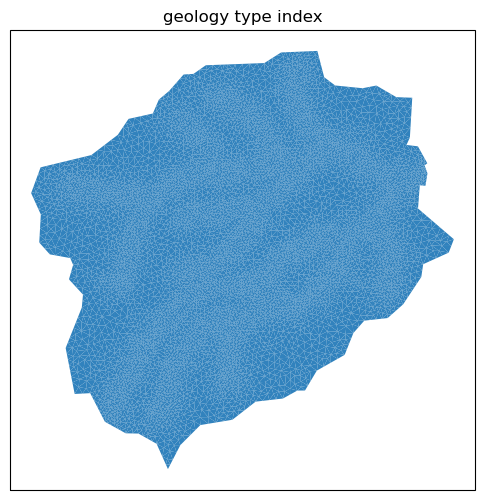

In [47]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap='tab20c')
ax.set_title('geology type index')
geo_survey_props



In [48]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)

# remove duplicates
reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
# assert geo_survey_props_clean['porosity [-]'][:].min() >= min_porosity
# assert geo_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
# assert geo_survey_props_clean['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geo_survey_props_clean

native_index   source  permeability [m^2]  porosity [-]  \
0   (1793338,)  GLHYMPS        3.019952e-11          0.01   

   van Genuchten alpha [Pa^-1]  van Genuchten n [-]  residual saturation [-]  
0                     0.023953                  2.0                     0.01

/opt/conda/envs/watershed_workflow/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


kwargs =  {'linewidth': 0, 'cmap': <matplotlib.colors.ListedColormap object at 0x40a20dd360>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x40a20dd300>}
setting face color =  [100 100 100 ... 100 100 100]


(273712.5998, 279399.40619999997, 3878583.92855, 3884209.4924500003)

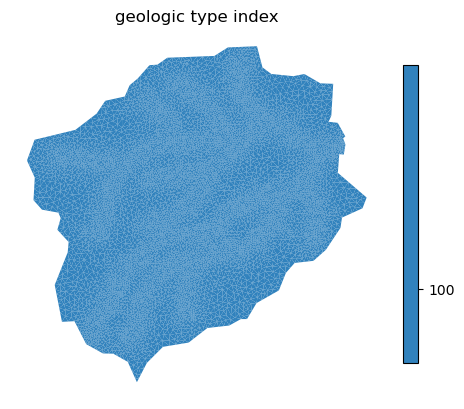

In [49]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+ new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [50]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 coweeta.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2023-06-30 15:36:47,640 - root - INFO: 
2023-06-30 15:36:47,644 - root - INFO: Loading Raster
2023-06-30 15:36:47,647 - root - INFO: ------------------------------
2023-06-30 15:36:47,666 - root - INFO: Collecting raster
2023-06-30 15:36:47,782 - root - INFO: bounds in my_crs: (-83.47845037186387, 35.02734099944037, -83.42165773504303, 35.07381933600275)
2023-06-30 15:36:47,808 - root - INFO: ... got raster of shape: (23, 28)
2023-06-30 15:36:47,816 - root - INFO: ... got raster bounds: (-83.47918210999998, 35.074175034, -83.42084878599998, 35.026258375)


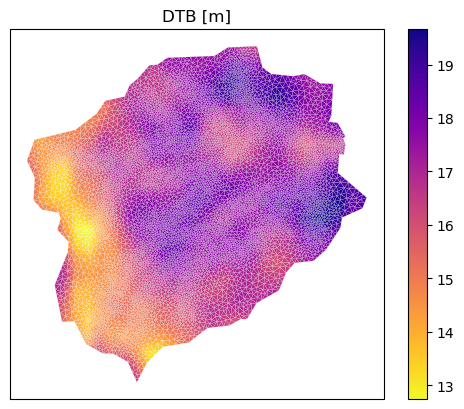

In [51]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [52]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

In [53]:
bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()
bedrock_props['source'] = 'SoilGrids'
bedrock_props['native_index'] = '(999,)'

In [54]:
# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])
subsurface_props

native_index     source  permeability [m^2]  porosity [-]  \
ats_id                                                                          
100                   (1793338,)    GLHYMPS        3.019952e-11      0.010000   
1000                   (545849,)       NRCS        3.429028e-15      0.307246   
1001                   (545855,)       NRCS        3.247236e-15      0.303714   
1002                   (545817,)       NRCS        2.800000e-12      0.379163   
1003                   (545887,)       NRCS        2.800000e-12      0.384877   
1004                   (545885,)       NRCS        1.830706e-12      0.329821   
1005                   (545886,)       NRCS        6.219065e-14      0.349442   
1006                   (545803,)       NRCS        6.060887e-14      0.346424   
1007            (545852, 545854)       NRCS        3.794887e-14      0.319402   
1008                   (545853,)       NRCS        2.800000e-12      0.242266   
1009                   (545857,)       NRCS        2.800000e-12      0.305511   
1010            (545818, 545820)       NRCS        2.800000e-12      0.313860   
1011    (545805, 545806, 545807)       NRCS        2.091075e-12      0.421416   
1012                   (545800,)       NRCS        1.689101e-12      0.420388   
1013                   (545801,)       NRCS        1.729105e-12      0.418625   
1014                   (545815,)       NRCS        9.069462e-13      0.375338   
1015                   (545819,)       NRCS        8.686821e-13      0.410934   
1016                   (545814,)       NRCS        9.140653e-13      0.353400   
1017                   (545813,)       NRCS        9.090539e-13      0.348524   
1018                   (545876,)       NRCS        9.952892e-13      0.386946   
1019                   (545882,)       NRCS        9.952892e-13      0.387980   
1020            (545811, 545812)       NRCS        6.249129e-12      0.171281   
1021                   (545842,)       NRCS        1.811809e-12      0.466299   
1022                   (545831,)       NRCS        1.811809e-12      0.466299   
1023                   (545830,)       NRCS        6.238368e-12      0.235555   
1024                   (545829,)       NRCS        4.981053e-15      0.405556   
1025                   (545878,)       NRCS        1.107558e-12      0.265930   
1026                   (545843,)       NRCS        1.035014e-12      0.269704   
1027                   (545861,)       NRCS        1.968721e-12      0.309901   
1028                   (545835,)       NRCS        1.131635e-12      0.270988   
1029            (545874, 545875)       NRCS        1.023505e-12      0.365616   
1030            (545862, 545863)       NRCS        2.800000e-12      0.324877   
1031                   (545859,)       NRCS        2.282599e-12      0.364041   
1032                   (545860,)       NRCS        2.800000e-12      0.280000   
1033                   (545837,)       NRCS        2.800000e-12      0.326502   
1034                   (545838,)       NRCS        2.800000e-12      0.306355   
1035                   (545836,)       NRCS        2.800000e-12      0.306355   
999                       (999,)  SoilGrids        1.000000e-16      0.050000   

        van Genuchten alpha [Pa^-1]  van Genuchten n [-]  \
ats_id                                                     
100                        0.023953             2.000000   
1000                       0.000139             1.470755   
1001                       0.000139             1.469513   
1002                       0.000150             1.491087   
1003                       0.000083             1.468789   
1004                       0.000166             1.473045   
1005                       0.000127             1.445858   
1006                       0.000125             1.445793   
1007                       0.000162             1.498482   
1008                       0.000168             1.559659   
1009                       0.000151             1.479294   

In [55]:
# save the properties to disk for use in generating input file
outputs['subsurface_properties_filename'] = os.path.join('..', '..', 'data', 'Coweeta', 'processed', 'coweeta_subsurface_properties.csv')
subsurface_props.to_csv(outputs['subsurface_properties_filename'])

Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [56]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
total_thickness = np.ceil(DTB.max())
logging.info(f'max DTB: {total_thickness} m')

2023-06-30 15:36:52,370 - root - INFO: max DTB: 20.0 m


In [57]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

[0.05723957 0.07235405 0.10008891 0.1503918  0.24391084 0.37797867
 0.49803617 0.5       ]


In [58]:
# this looks like it would work out:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]

In [59]:
# a 2m soil thickness and a maximum of 20m depth to bedrock suggests a
# geologic layer of 9 - 2m cells or something finer
dzs_geo = [2.0]*9

In [60]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2023-06-30 15:36:53,882 - root - INFO: Cell summary:
2023-06-30 15:36:53,884 - root - INFO: ------------------------------------------------------------
2023-06-30 15:36:53,886 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2023-06-30 15:36:53,889 - root - INFO: ------------------------------------------------------------
2023-06-30 15:36:53,895 - root - INFO:  00 	| 00 	| 1019 	|   0.050000 	|   0.000000
2023-06-30 15:36:53,897 - root - INFO:  01 	| 01 	| 1019 	|   0.050000 	|   0.050000
2023-06-30 15:36:53,899 - root - INFO:  02 	| 02 	| 1019 	|   0.050000 	|   0.100000
2023-06-30 15:36:53,901 - root - INFO:  03 	| 03 	| 1019 	|   0.120000 	|   0.150000
2023-06-30 15:36:53,904 - root - INFO:  04 	| 04 	| 1019 	|   0.230000 	|   0.270000
2023-06-30 15:36:53,907 - root - INFO:  05 	| 05 	| 1019 	|   0.500000 	|   0.500000
2023-06-30 15:36:53,910 - root - INFO:  06 	| 06 	| 1019 	|   0.500000 	|   1.000000
2023-06-30 15:36:53,913 - root - INFO:  07 	| 07 	| 1019 	|   0.500000 	|   1.5

In [61]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [62]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = watershed_workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.cell_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [63]:
print(f'total number of cells: {m3.num_cells}')
print('---------------')
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
ls = m3.labeled_sets
for i in ls:
    print(f'{i.setid} : {i.entity} : {len(i.ent_ids)} : "{i.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
ss = m3.side_sets
for i in ss:
    print(f'{i.setid} : FACE : {len(i.cell_list)} : "{i.name}"')

total number of cells: 270504
---------------
2D labeled sets
---------------
10000 : CELL : 15912 : "060102020103"
10001 : CELL : 15912 : "060102020103 surface"
10002 : FACE : 226 : "060102020103 boundary"
10003 : FACE : 0 : "060102020103 outlet"

Extruded 3D labeled sets
------------------------
10000 : CELL : 270504 : "060102020103"

Extruded 3D side sets
---------------------
1 : FACE : 15912 : "bottom"
2 : FACE : 15912 : "surface"
3 : FACE : 3842 : "external_sides"
10001 : FACE : 15912 : "060102020103 surface"
10002 : FACE : 3842 : "060102020103 boundary"
10003 : FACE : 0 : "060102020103 outlet"
21 : FACE : 704 : "Developed, Open Space"
22 : FACE : 4 : "Developed, Low Intensity"
23 : FACE : 2 : "Developed, Medium Intensity"
41 : FACE : 7795 : "Deciduous Forest"
42 : FACE : 291 : "Evergreen Forest"
43 : FACE : 7080 : "Mixed Forest"
52 : FACE : 4 : "Shrub/Scrub"
81 : FACE : 32 : "Pasture/Hay"


### Save mesh file

This will write the 3D mesh to ExodusII using arbitrary polyhedra specification. 

In [64]:
outputs['mesh_filename'] = os.path.join('..', '..', 'data', 'Coweeta', 'processed','coweeta_mesh.exo')

try:
    os.remove(outputs['mesh_filename'])
except FileNotFoundError:
    pass
m3.write_exodus(outputs['mesh_filename'])


You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../../data/Coweeta/processed/coweeta_mesh.exo


2023-06-30 15:41:55,553 - root - INFO: adding side set: 1
2023-06-30 15:42:03,658 - root - INFO: adding side set: 2
2023-06-30 15:42:11,825 - root - INFO: adding side set: 3
2023-06-30 15:42:20,045 - root - INFO: adding side set: 10001
2023-06-30 15:42:28,237 - root - INFO: adding side set: 10002
2023-06-30 15:42:36,825 - root - INFO: adding side set: 10003
2023-06-30 15:42:36,849 - root - INFO: adding side set: 21
2023-06-30 15:42:47,323 - root - INFO: adding side set: 22
2023-06-30 15:42:55,816 - root - INFO: adding side set: 23
2023-06-30 15:43:04,051 - root - INFO: adding side set: 41
2023-06-30 15:43:13,382 - root - INFO: adding side set: 42
2023-06-30 15:43:21,664 - root - INFO: adding side set: 43
2023-06-30 15:43:30,216 - root - INFO: adding side set: 52
2023-06-30 15:43:38,370 - root - INFO: adding side set: 81
2023-06-30 15:43:47,171 - root - INFO: adding elem set: 10000


Closing exodus file: ../../data/Coweeta/processed/coweeta_mesh.exo


In [65]:
outputs

{'subsurface_properties_filename': '../../data/Coweeta/processed/coweeta_subsurface_properties.csv',
 'mesh_filename': '../../data/Coweeta/processed/coweeta_mesh.exo'}